In [1]:
import sys
sys.path.append('..')
from scripts.data_analysis import DataAnalysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
original_df = pd.read_csv('../data/data_wave1.csv')

In [3]:
columns_to_extract = [
    'pident', 'aApoB', 'aHDL_C', 'aTotFA', 'aSerum_TG', 'aGp', 'aIle', 'Sexe', 'Age',
    'aauditsc', 'aedu', 'AIPMETO2', 'asmokstat', 'acidep09', 'ahsCRP', 'aIL6',
    'aIRSsum9', 'ams_waist', 'ams_hpt', 'ams_trig2', 'ams_hdl2', 'ams_gluc2',
    'amet_syn2', 'atri_med', 'ahdl_med', 'asbp_med', 'adbp_med', 'agluc_med', 'abaiscal',
    'aids'
]

extracted_df = original_df[columns_to_extract]

extracted_csv_file = '../data/wave1_data_to_discretize.csv'
extracted_df.to_csv(extracted_csv_file, index=False)

In [4]:
def classify_data(df):
    """
    Classify each column in a pandas DataFrame as continuous, discrete, binary, or categorical.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to classify.

    Returns:
    dict: A dictionary with column names as keys and their classifications as values.
    """
    def classify_series(series):
        """
        Classify a pandas Series as continuous, discrete, binary, or categorical.
        
        Parameters:
        series (pd.Series): The Series from a column to classify.

        Returns:
        str: The classification of the series ('continuous', 'discrete', 'binary', 'categorical').
        """
        if pd.api.types.is_numeric_dtype(series):
            unique_count = series.nunique()
            total_count = len(series)
            
            if unique_count == 2:
                return 'binary'
            elif unique_count < 10:
                return 'discrete'
            else:
                return 'continuous'
        else:
            return 'categorical'

    column_classifications = {col: classify_series(df[col]) for col in df.columns}
    return column_classifications

In [5]:
data = pd.read_csv('../data/wave1_data_to_discretize.csv')

In [6]:
# replace -1 in columns with NaN
columns_with_minus_one = [
    'ahsCRP', 'aIL6', 'ams_waist', 'ams_hpt', 'ams_trig2', 'ams_hdl2', 'ams_gluc2',
    'amet_syn2'
]

for col in columns_with_minus_one:  
  data[col] = data[col].replace(-1, np.nan)

# in sleeping pattern, -3 and -2 means no data
data['aIRSsum9'] = data[col].replace(-3, np.nan)
data['aIRSsum9'] = data[col].replace(-2, np.nan)

In [7]:
column_types = classify_data(data)
column_types

{'pident': 'continuous',
 'aApoB': 'continuous',
 'aHDL_C': 'continuous',
 'aTotFA': 'continuous',
 'aSerum_TG': 'continuous',
 'aGp': 'continuous',
 'aIle': 'continuous',
 'Sexe': 'binary',
 'Age': 'continuous',
 'aauditsc': 'continuous',
 'aedu': 'discrete',
 'AIPMETO2': 'continuous',
 'asmokstat': 'discrete',
 'acidep09': 'binary',
 'ahsCRP': 'continuous',
 'aIL6': 'continuous',
 'aIRSsum9': 'binary',
 'ams_waist': 'binary',
 'ams_hpt': 'binary',
 'ams_trig2': 'binary',
 'ams_hdl2': 'binary',
 'ams_gluc2': 'binary',
 'amet_syn2': 'binary',
 'atri_med': 'continuous',
 'ahdl_med': 'continuous',
 'asbp_med': 'continuous',
 'adbp_med': 'continuous',
 'agluc_med': 'continuous',
 'abaiscal': 'continuous',
 'aids': 'continuous'}

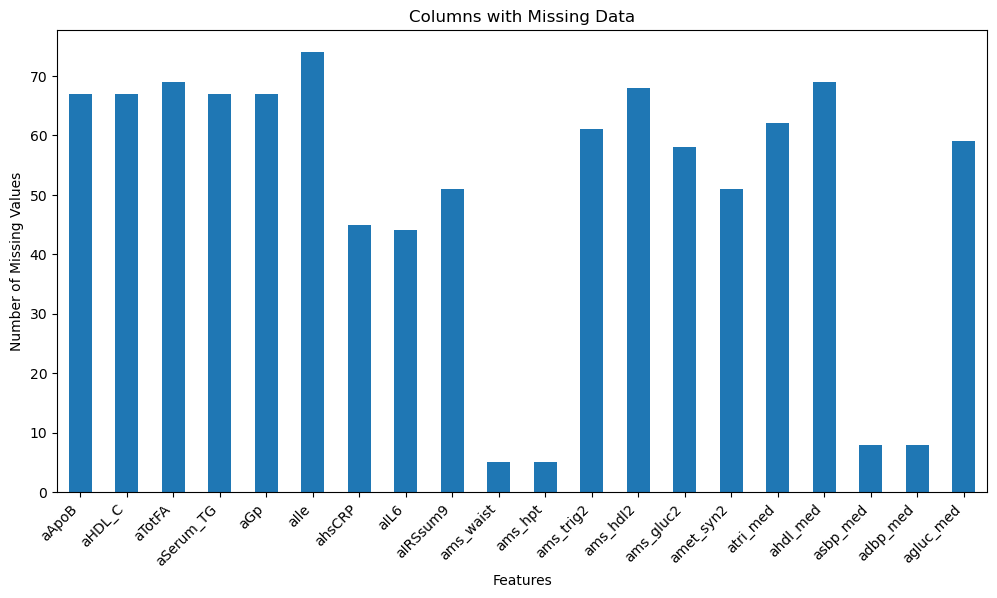

In [8]:
DataAnalysis.plot_missing_values(data)

In [9]:
from scipy.stats import chi2_contingency

def perform_little_mcar_test(df):
    results = []

    for col_with_missing_data in df.columns[df.isnull().any()]:
        # Create a mask indicating where data is missing
        missing_data = df[col_with_missing_data ].isnull().astype(int)

        # Create contingency table for Chi-Squared test
        contingency_table = pd.crosstab(missing_data, df.drop(columns=[col_with_missing_data]).isnull().any(axis=1).astype(int))

        # Perform Chi-Squared test
        chi2_stat, p_val, dof, _ = chi2_contingency(contingency_table, correction=False)

        # Append results
        results.append({'Column': col_with_missing_data, 'Chi-Squared': chi2_stat, 'df': dof, 'p-value': p_val})

    return pd.DataFrame(results)

perform_little_mcar_test(data)

,Column,Chi-Squared,df,p-value
0,aApoB,1192.689216,1,2.366685e-261
1,aHDL_C,1192.689216,1,2.366685e-261
2,aTotFA,1170.260119,1,1.772852e-256
3,aSerum_TG,1192.689216,1,2.366685e-261
4,aGp,1192.689216,1,2.366685e-261
5,aIle,1121.201412,1,8.145515e-246
6,ahsCRP,731.676390,1,3.869721e-161
7,aIL6,745.094714,1,4.677265e-164
8,aIRSsum9,902.910271,1,2.286462e-198
9,ams_waist,54.552608,1,1.513416e-13


Data is not missing completely at random so we cannot discard it

In [10]:
columns_to_process = [col for col in columns_to_extract if col != 'pident']

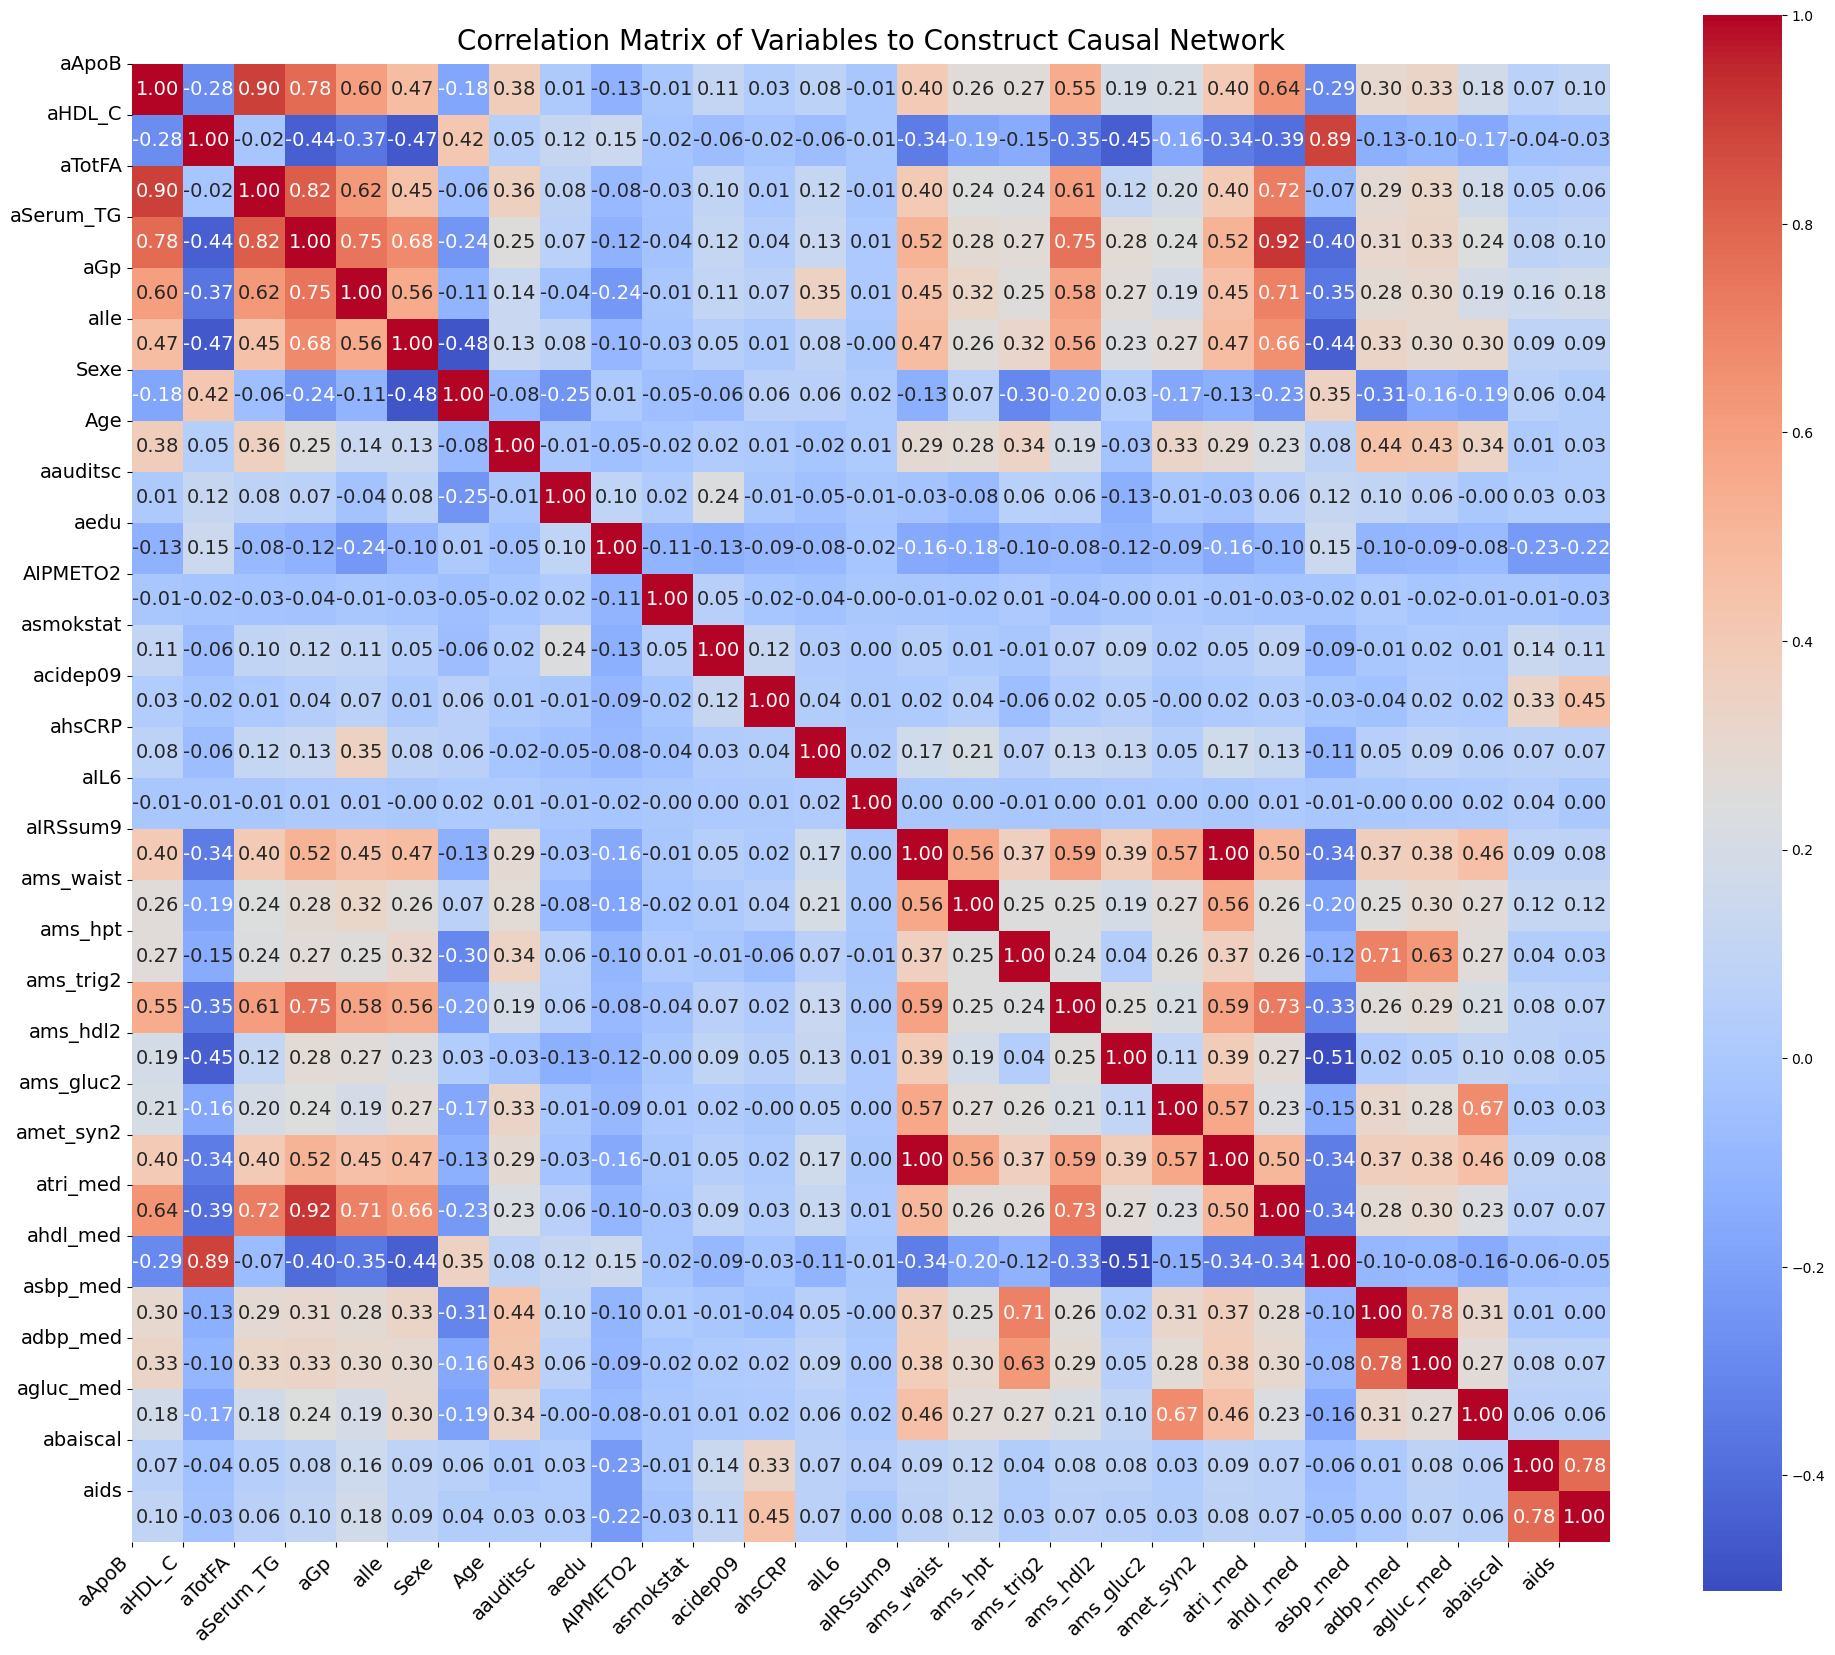

In [11]:
DataAnalysis.plot_correlation_matrix(data[columns_to_process], columns_to_process, 'Variables to Construct Causal Network')

Now, we are going to impute the missing data with MICE

In [29]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold

def multiple_imputation(df, column_types, max_iter=10):
    variable_importance = {}

    rf_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=max_iter, random_state=42)

    imputed_df = df.copy()

    if 'amet_syn2' in df.columns:
        correlated_vars = ['ams_trig2', 'ams_hdl2', 'ams_hpt', 'ams_gluc2', 'atri_med', 'ahdl_med', 'asbp_med', 'adbp_med', 'agluc_med']
        imputation_vars = ['amet_syn2'] + correlated_vars
        data_for_imputation = df[imputation_vars]

        imputed_data = rf_imputer.fit_transform(data_for_imputation)
        # convert to binary
        imputed_df['amet_syn2'] = np.round(imputed_data[:, 0]).astype(int)

    for col in df.columns[df.isnull().any()]:
        if col == 'amet_syn2':
            continue

        imputed_data = rf_imputer.fit_transform(df[[col]])
        imputed_df[col] = imputed_data[:, 0]

        if column_types[col] == 'binary':
            imputed_df[col] = np.round(imputed_df[col]).astype(int)

        # Assess variable importance
        if col not in variable_importance:
            rf_estimator = RandomForestRegressor()
            rf_estimator.fit(df.dropna().drop(col, axis=1), df.dropna()[col])
            importances = rf_estimator.feature_importances_
            feature_importances = {feature: importance for feature, importance in zip(df.dropna().drop(col, axis=1).columns, importances)}
            variable_importance[col] = feature_importances

    return imputed_df, variable_importance

In [30]:
imputed_df, variable_importance = multiple_imputation(data[columns_to_process], column_types, max_iter=10)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [32]:
DataAnalysis.plot_missing_values(imputed_df)

No missing values


In [33]:
classify_data(imputed_df)

{'aApoB': 'continuous',
 'aHDL_C': 'continuous',
 'aTotFA': 'continuous',
 'aSerum_TG': 'continuous',
 'aGp': 'continuous',
 'aIle': 'continuous',
 'Sexe': 'binary',
 'Age': 'continuous',
 'aauditsc': 'continuous',
 'aedu': 'discrete',
 'AIPMETO2': 'continuous',
 'asmokstat': 'discrete',
 'acidep09': 'binary',
 'ahsCRP': 'continuous',
 'aIL6': 'continuous',
 'aIRSsum9': 'binary',
 'ams_waist': 'binary',
 'ams_hpt': 'binary',
 'ams_trig2': 'binary',
 'ams_hdl2': 'binary',
 'ams_gluc2': 'binary',
 'amet_syn2': 'binary',
 'atri_med': 'continuous',
 'ahdl_med': 'continuous',
 'asbp_med': 'continuous',
 'adbp_med': 'continuous',
 'agluc_med': 'continuous',
 'abaiscal': 'continuous',
 'aids': 'continuous'}

In [34]:
imputed_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)
imputed_df['pident'] = data['pident']
imputed_df.set_index('pident', inplace=True)

In [35]:
imputed_df.to_csv('../data/network/imputed_data_wave1.csv')

## Transform continuous variables to discrete

In [36]:
preprocessed_df = pd.read_csv('../data/network/imputed_data_wave1.csv')

In [37]:
preprocessed_df

,pident,aApoB,aHDL_C,aTotFA,aSerum_TG,aGp,aIle,Sexe,Age,aauditsc,...,ams_hdl2,ams_gluc2,amet_syn2,atri_med,ahdl_med,asbp_med,adbp_med,agluc_med,abaiscal,aids
0,100001,0.7924,1.3100,8.860,0.6981,1.338,0.03871,2,49,1,...,0,0,0,0.60,1.48,128.5,75.0,5.2,2,15
1,100002,0.7848,1.0360,9.495,1.2740,1.216,0.05726,1,41,10,...,0,0,0,1.40,1.21,142.5,77.0,5.1,11,16
2,100003,1.1920,1.2290,13.120,1.2940,1.299,0.04489,2,60,6,...,1,0,0,1.20,1.29,121.0,73.5,5.5,4,11
3,100004,1.2400,1.1460,13.270,1.3890,1.217,0.04463,1,54,3,...,0,0,0,1.20,1.24,139.0,90.0,4.5,0,3
4,100005,1.1340,1.7380,14.060,1.1200,1.318,0.03017,1,56,7,...,0,1,0,1.10,1.97,117.5,69.0,6.1,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2976,330386,1.0210,0.9572,11.280,1.5500,1.341,0.05670,1,19,-3,...,1,0,0,1.64,1.00,124.5,69.0,4.6,-2,-2
2977,330388,0.7230,0.9483,8.585,0.9465,1.321,0.03439,1,18,3,...,0,0,0,1.01,1.10,133.5,76.5,4.7,2,1
2978,330389,0.7411,1.6150,10.120,0.9236,1.352,0.04446,1,24,15,...,0,0,0,1.03,2.10,124.0,69.0,4.9,6,4
2979,330392,0.8344,1.3510,10.780,1.0420,1.334,0.05103,2,25,6,...,0,0,0,1.13,1.40,127.5,70.5,4.5,2,17


In [38]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def apply_kmeans(df, column_name, n_clusters=3, random_state=0):
    data = df[column_name].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(data)
    
    centroids = kmeans.cluster_centers_
    sorted_idx = np.argsort(centroids.ravel())

    # 1 for "Low", 2 for "Moderate", 3 for "High"
    ordinal_labels = {old_label: new_label for old_label, new_label in zip(sorted_idx, range(1, n_clusters + 1))}
    df[column_name] = [ordinal_labels[x] for x in kmeans.labels_]
    
    colors = ['#3B28CC', '#3F8EFC', '#ADD7F6']
    plt.figure(figsize=(8, 6))
    for label in range(1, n_clusters + 1):
        subset = df[df[f'{column_name}'] == label]
        plt.hist(subset[f'{column_name}'], bins=np.arange(1, n_clusters + 2) - 0.5, color=colors[label-1], label=f'Cluster {label}', alpha=0.75, edgecolor='black')

    plt.title(f'Clusters of {column_name}')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.xticks(range(1, n_clusters + 1))
    plt.legend()
    plt.show()
    
    return df


In [39]:
#aApoB
bins = [-float('inf'), 1.3, float('inf')]
# Low: 1, High: 2
labels = [1, 2]
preprocessed_df['aApoB'] = pd.cut(preprocessed_df['aApoB'], bins=bins, labels=labels, right=False)
preprocessed_df['aApoB'].unique()


[1, 2]
Categories (2, int64): [1 < 2]

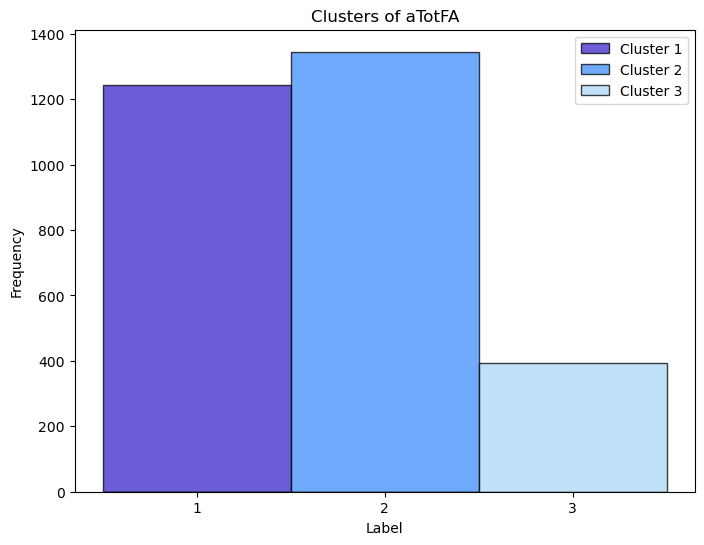

In [40]:
#aTotFA
preprocessed_df = apply_kmeans(preprocessed_df, 'aTotFA', n_clusters=3, random_state=0)


In [41]:
preprocessed_df['aHDL_C'] = preprocessed_df.apply(
    lambda row: 1 if (row['Sexe'] == 1 and row['aHDL_C'] > 1.03) or (row['Sexe'] == 2 and row['aHDL_C'] > 1.29) else 2,
    axis=1
)

# Desirable: 1, At risk: 2

In [42]:
bins = [-float('inf'), 1.69, 2.26, 5.65, float('inf')]
# 'Desirable': 1, 'Mild Hypertriglyceridemia': 2, 'High Hypertriglyceridemia': 3, 'Very High Hypertriglyceridemia': 4
labels = [1, 2, 3, 4]
preprocessed_df['aSerum_TG'] = pd.cut(preprocessed_df['aSerum_TG'], bins=bins, labels=labels)
preprocessed_df['aSerum_TG'].unique()


[1, 3, 2, 4]
Categories (4, int64): [1 < 2 < 3 < 4]

In [43]:
preprocessed_df['aGp'] = preprocessed_df['aGp'].apply(lambda x: 1 if x <= 1.2 else 2)
preprocessed_df['aGp'].unique()
# Normal: 1, At risk: 2

array([2, 1])

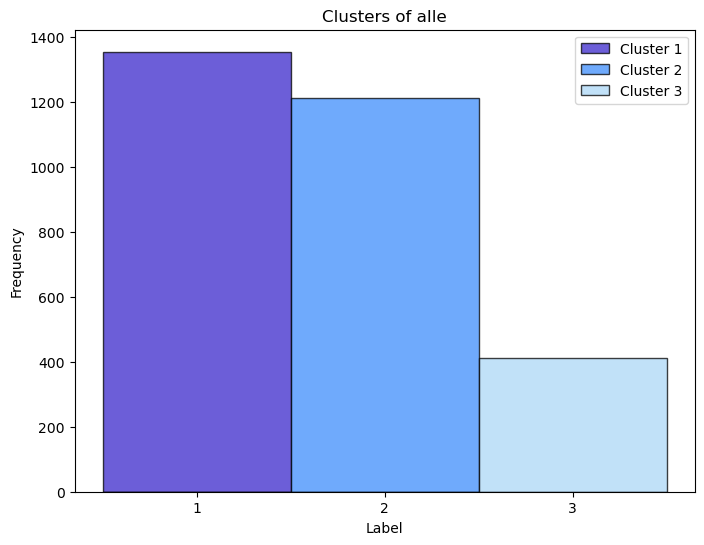

In [44]:
preprocessed_df = apply_kmeans(preprocessed_df, 'aIle', n_clusters=3, random_state=0)



In [45]:
def categorize_met(met):
    moderate = 4.9 * 60 * 3 # assuming 3 sessions of 1 hour each per week
    vigorous = 6.8 * 60 * 3
    if met >= moderate and met < vigorous:  
        return 2 # Moderate
    elif met >= 6.8 * 60 * 3: 
        return 3 # Vigorous
    else:
        return 1 # Low

preprocessed_df['AIPMETO2'] = preprocessed_df['AIPMETO2'].apply(categorize_met)
print(preprocessed_df['AIPMETO2'].value_counts())

AIPMETO2
3    2237
1     568
2     176
Name: count, dtype: int64


In [46]:
preprocessed_df['aIL6'] = pd.cut(preprocessed_df['aIL6'],
                                bins=[-float('inf'), 7, float('inf')],
                                labels=[1, 2], # Normal: 1, High: 2
                                right=True) 

print(preprocessed_df['aIL6'].value_counts())

aIL6
1    2941
2      40
Name: count, dtype: int64


In [47]:
preprocessed_df['ahsCRP'] = pd.cut(preprocessed_df['ahsCRP'],
                                  bins=[-float('inf'), 0.3, 1, 10, 50, float('inf')],
                                  labels=[1, 2, 3, 4, 5],
                                  right=False)
print(preprocessed_df['ahsCRP'].value_counts())
# Normal: 1, Minor: 2, Moderate: 3, Marked: 4, Severe: 5

ahsCRP
3    1558
2     906
1     368
4     142
5       7
Name: count, dtype: int64


In [48]:
def categorize_atri_med(row):
    adult_threshold = 150 * 0.01129  # mg/dL to mmol/L for adults
    child_threshold = 90 * 0.01129   # mg/dL to mmol/L for children and teens

    if row['Age'] > 19:
        if row['atri_med'] < adult_threshold:
            return 1 # Healthy
        else:
            return 2 # High
    else: 
        if row['atri_med'] < child_threshold:
            return 1 # Healthy
        else:
            return 2 # High

preprocessed_df['atri_med'] = preprocessed_df.apply(categorize_atri_med, axis=1)
print(preprocessed_df['atri_med'].value_counts())


atri_med
1    2357
2     624
Name: count, dtype: int64


In [49]:
def categorize_ahdl_med(row):
    if row['Sexe'] == 1: 
        return 1 if row['ahdl_med'] > 1.0 else 2
    elif row['Sexe'] == 2: 
        return 1 if row['ahdl_med'] > 1.2 else 2

preprocessed_df['ahdl_med'] = preprocessed_df.apply(categorize_ahdl_med, axis=1)
preprocessed_df['ahdl_med'].value_counts()
# Healthy: 1, Unhealthy: 2

ahdl_med
1    2670
2     311
Name: count, dtype: int64

In [50]:
def categorize_blood_pressure(df):
    for index, row in df.iterrows():
        sbp = row['asbp_med']
        dbp = row['adbp_med']
        
        if sbp < 122 and dbp < 80:
            df.at[index, 'asbp_med'] = 1 
            df.at[index, 'adbp_med'] = 1
        elif 120 <= sbp <= 129 and dbp < 80:
            df.at[index, 'asbp_med'] = 2
            df.at[index, 'adbp_med'] = 2
        elif (130 <= sbp <= 139 or 80 <= dbp <= 89):
            df.at[index, 'asbp_med'] = 3
            df.at[index, 'adbp_med'] = 3
        elif sbp >= 140 or dbp >= 90:
            df.at[index, 'asbp_med'] = 4
            df.at[index, 'adbp_med'] = 4
        else:
            df.at[index, 'asbp_med'] = -1
            df.at[index, 'adbp_med'] = -1

categorize_blood_pressure(preprocessed_df)
# Normal: 1, Elevated: 2, Hypertension I: 3, Hypertension II: 4, Uncategorized: -1

In [51]:
def categorize_glucose_level(glucose_mmol):
    glucose_mg_dl = glucose_mmol * 18  # convert mmol/L to mg/dL
    if glucose_mg_dl < 70:
        return 1 # Hypoglycemia
    elif 70 <= glucose_mg_dl <= 100:
        return 2 # Normal
    elif 100 < glucose_mg_dl <= 125:
        return 3 # Prediabetes
    elif glucose_mg_dl >= 126:
        return 4 # Diabetes
    else:
        return -1

preprocessed_df['agluc_med'] = preprocessed_df['agluc_med'].apply(categorize_glucose_level)

preprocessed_df['agluc_med'].value_counts()

agluc_med
2    2308
3     500
4     143
1      30
Name: count, dtype: int64

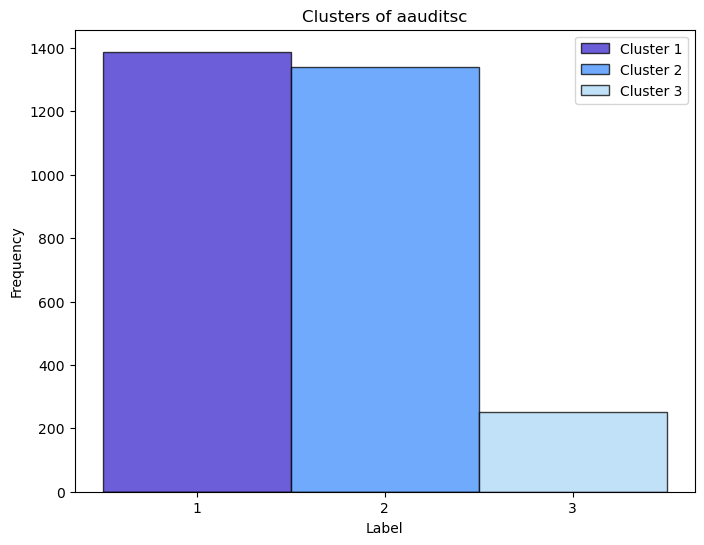

In [52]:
preprocessed_df = apply_kmeans(preprocessed_df, 'aauditsc', n_clusters=3, random_state=0)

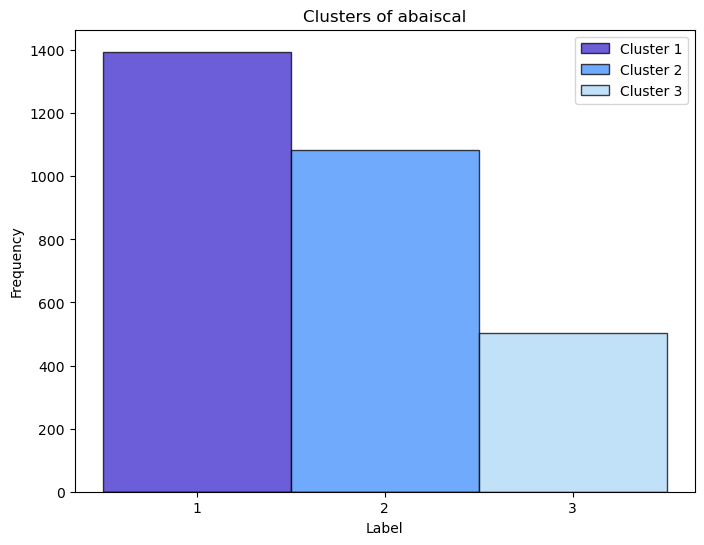

In [53]:
preprocessed_df = apply_kmeans(preprocessed_df, 'abaiscal', n_clusters=3, random_state=0)

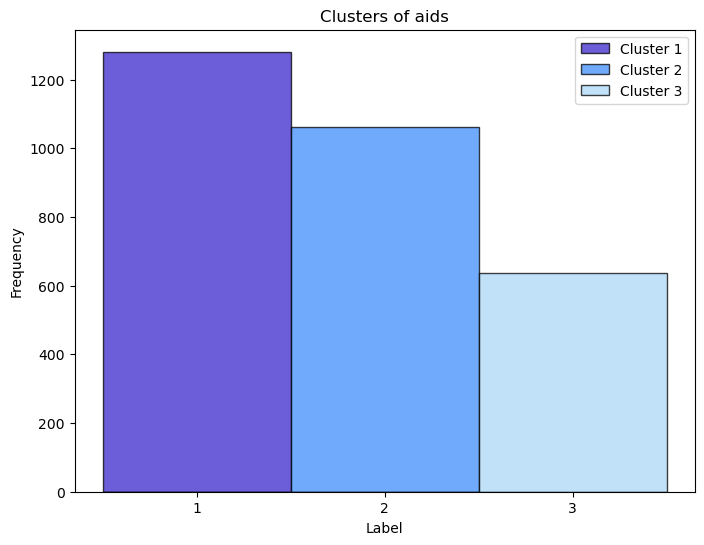

In [54]:
preprocessed_df = apply_kmeans(preprocessed_df, 'aids', n_clusters=3, random_state=0)

In [55]:
def discretize_age(data, column, bins, labels):
    bin_indices = np.digitize(data[column], bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(labels) - 1)
    return [labels[i] for i in bin_indices]

In [56]:
bins = [18, 27, 50, float('inf')]
labels = [1, 2, 3] 
preprocessed_df['Age'] = discretize_age(preprocessed_df, 'Age', bins, labels)
# Young Adult: 1, Adult: 2, Elderly: 3

In [57]:
# save data to build the network
preprocessed_df.to_csv('../data/network/discrete_mice_wave1.csv', index=False)

In [58]:
final_data = pd.read_csv('../data/network/discrete_mice_wave1.csv')
classify_data(final_data[columns_to_process])

{'aApoB': 'binary',
 'aHDL_C': 'binary',
 'aTotFA': 'discrete',
 'aSerum_TG': 'discrete',
 'aGp': 'binary',
 'aIle': 'discrete',
 'Sexe': 'binary',
 'Age': 'discrete',
 'aauditsc': 'discrete',
 'aedu': 'discrete',
 'AIPMETO2': 'discrete',
 'asmokstat': 'discrete',
 'acidep09': 'binary',
 'ahsCRP': 'discrete',
 'aIL6': 'binary',
 'aIRSsum9': 'binary',
 'ams_waist': 'binary',
 'ams_hpt': 'binary',
 'ams_trig2': 'binary',
 'ams_hdl2': 'binary',
 'ams_gluc2': 'binary',
 'amet_syn2': 'binary',
 'atri_med': 'binary',
 'ahdl_med': 'binary',
 'asbp_med': 'discrete',
 'adbp_med': 'discrete',
 'agluc_med': 'discrete',
 'abaiscal': 'discrete',
 'aids': 'discrete'}